# Домашняя работа 2
 Изучение GCN, GraphSAGE, GAT, GIN — на задачах "node classification" и "link prediction"

автор: `Алексеева Валентина`


В этой домашней работе вам предстоит:

- освоить и углубить понимание нескольких графовых нейросетевых архитектур (GCN, GraphSAGE, GAT, GIN)
-  применить их к задачам классификации узлов и предсказания рёбер
- исследовать влияние глубины, скрытой размерности, оптимизации GNN на качество обучения
- построить сравнительные эксперименты и сделать собственные выводы о преимуществах разных подходов

In [1]:
# !pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.3 MB/s eta 0:00:0000:01


In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GINConv, SAGEConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import dropout_edge
from torch_geometric.nn import SAGEConv, GATv2Conv
import networkx as nx

import torch.nn as nn
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Загрузка и визуализация данных

Датасет: Cora - Граф научных цитирований

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


# Часть 1. Node Classification

### 1.1 Реализация расширенного GCN

Создайте GCN-модель с:

- тремя слоями GCNConv,
- Dropout после второго слоя,
- активацией ReLU в скрытых слоях.

**Вопросы:**

- Улучшилось ли качество на Cora в сравнении с результатом, который был получен на практике?
- Как изменилась динамика сходимости?
- Наблюдается ли переобучение?

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

data = data.to(device)

def train_node(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_node(model, data):
    model.eval()
    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        # mask.sum() — число объектов в маске
        acc = (pred[mask] == data.y[mask]).sum().item() / int(mask.sum())
        accs.append(acc)
    return accs  # [train_acc, val_acc, test_acc]

Device: cpu


In [5]:
# TODO
class GCN3(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # первый слой
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # второй слой
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Dropout после второго скрытого слоя
        x = F.dropout(x, p=self.dropout, training=self.training)

        # выходной слой (логиты классов)
        x = self.conv3(x, edge_index)
        return x


hidden_dim = 64
dropout = 0.5
epochs = 200

model_gcn3 = GCN3(
    in_dim=data.num_features,
    hidden_dim=hidden_dim,
    out_dim=dataset.num_classes,
    dropout=dropout
).to(device)

optimizer = torch.optim.Adam(
    model_gcn3.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

train_losses = []
train_accs = []
val_accs = []
test_accs = []

for epoch in range(1, epochs + 1):
    loss = train_node(model_gcn3, data, optimizer)
    train_acc, val_acc, test_acc = eval_node(model_gcn3, data)

    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if epoch % 20 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {loss:.4f} | "
            f"Train: {train_acc:.3f} | "
            f"Val: {val_acc:.3f} | "
            f"Test: {test_acc:.3f}"
        )

Epoch 001 | Loss: 1.9541 | Train: 0.500 | Val: 0.258 | Test: 0.280
Epoch 020 | Loss: 0.0108 | Train: 1.000 | Val: 0.768 | Test: 0.774
Epoch 040 | Loss: 0.0023 | Train: 1.000 | Val: 0.772 | Test: 0.795
Epoch 060 | Loss: 0.0044 | Train: 1.000 | Val: 0.764 | Test: 0.785
Epoch 080 | Loss: 0.0045 | Train: 1.000 | Val: 0.772 | Test: 0.807
Epoch 100 | Loss: 0.0065 | Train: 1.000 | Val: 0.774 | Test: 0.811
Epoch 120 | Loss: 0.0058 | Train: 1.000 | Val: 0.762 | Test: 0.793
Epoch 140 | Loss: 0.0038 | Train: 1.000 | Val: 0.780 | Test: 0.800
Epoch 160 | Loss: 0.0059 | Train: 1.000 | Val: 0.774 | Test: 0.810
Epoch 180 | Loss: 0.0095 | Train: 1.000 | Val: 0.772 | Test: 0.807
Epoch 200 | Loss: 0.0033 | Train: 1.000 | Val: 0.774 | Test: 0.800


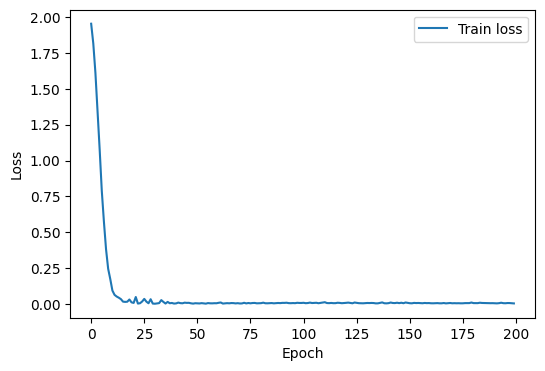

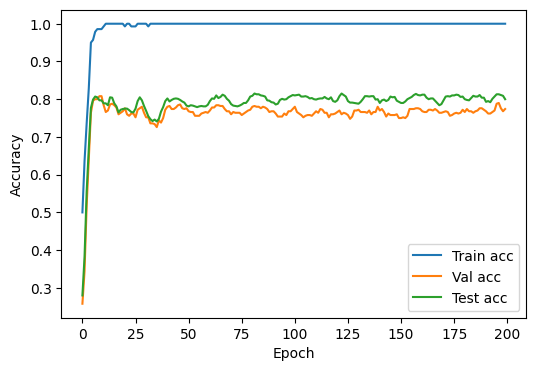

In [6]:
# визуализация динамики ошибки
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# визуализация точности
plt.figure(figsize=(6, 4))
plt.plot(train_accs, label="Train acc")
plt.plot(val_accs, label="Val acc")
plt.plot(test_accs, label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Вывод по пункту 1.1

В данной части реализована трёхслойная GCN-модель с нелинейностью ReLU в скрытых слоях и Dropout после второго сверточного слоя. На датасете Cora модель демонстрирует быстрый рост точности на обучающей выборке и достигает полного запоминания данных (`train accuracy = 1.0` уже к ~20-й эпохе).  

Валидационная точность стабилизируется в диапазоне `0.768–0.780`, а максимальная тестовая точность достигает 0.811. Этот результат сопоставим с базовой двухслойной GCN из практики (`0.785`), но небольшое улучшение тестовой точности указывает на выигрыш от увеличения глубины.  

Сильный разрыв между `train accuracy (1.0)` и `val/test accuracy (~0.77–0.81)` свидетельствует о переобучении модели, что характерно для глубоких GCN на Cora. Dropout снижает выраженность переобучения: валидационная точность остаётся стабильной и не деградирует к концу обучения.  

### 1.2 Исследование глубины признакового пространства

Проведите эксперимент с различными значениями скрытой размерности:

```
hidden_dim = 8, 16, 32, 64
```

Постройте таблицу:

| Hidden Dim | Train Acc | Val Acc | Test Acc |
|| ----| --| ---|

**Вопросы:**

- Сравните полученные результаты
- Влияет ли размерность на качество обучения?


In [7]:
# TODO

def run_gcn_experiment(hidden_dim, epochs=150, lr=0.01):
    """
    Обучает трёхслойную GCN (та же архитектура, что в 1.1)
    и возвращает final train/val/test accuracy.
    """
    model = GCN3(
        in_dim=data.num_features,
        hidden_dim=hidden_dim,
        out_dim=dataset.num_classes,
        dropout=0.5
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=5e-4
    )

    best_val = 0
    best_test = 0
    last_train = 0

    for epoch in range(epochs):
        loss = train_node(model, data, optimizer)
        train_acc, val_acc, test_acc = eval_node(model, data)

        # сохраняем лучший val, и тест при этом val
        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc

        last_train = train_acc

    return last_train, best_val, best_test


hidden_dims = [8, 16, 32, 64]
results = []

for h in hidden_dims:
    print(f"Running hidden_dim = {h} ...")
    train_acc, val_acc, test_acc = run_gcn_experiment(h)
    results.append({
        "Hidden Dim": h,
        "Train Acc": train_acc,
        "Val Acc": val_acc,
        "Test Acc": test_acc
    })

df_hidden = pd.DataFrame(results)
df_hidden

Running hidden_dim = 8 ...
Running hidden_dim = 16 ...
Running hidden_dim = 32 ...
Running hidden_dim = 64 ...


,Hidden Dim,Train Acc,Val Acc,Test Acc
0,8,1.0,0.750,0.752
1,16,1.0,0.786,0.781
2,32,1.0,0.786,0.805
3,64,1.0,0.792,0.820


### Вывод по пункту 1.2

В эксперименте варьировалась скрытая размерность трёхслойной GCN-модели: `8, 16, 32` и `64`. Во всех случаях модель полностью осваивает обучающую выборку (`train accuracy = 1.0`), однако качество на валидации и тесте заметно зависит от размерности скрытого пространства.

При `hidden_dim = 8` валидационная и тестовая точности остаются на более низком уровне (`Val = 0.750`, `Test = 0.752`), что указывает на недостаточную выразительность модели. Увеличение размерности до `16` и `32` приводит к росту качества: для `hidden_dim = 32` достигаются `Val = 0.786` и `Test = 0.805`. Наибольшая тестовая точность наблюдается при `hidden_dim = 64` (`Val = 0.792`, `Test = 0.820`), что свидетельствует о дополнительном выигрыше от увеличения числа параметров.

В целом, небольшие значения скрытой размерности приводят к недообучению на уровне обобщения, тогда как диапазон 32–64 даёт более высокий баланс между выразительностью модели и качеством на валидации и тесте.

### 1.3 Исследование нормализаций

Добавьте BatchNorm / LayerNorm / PairNorm (можно комбинировать) между слоями GCN и сравните:

- скорость сходимости,
- валидационную точность,
- чувствительность к learning rate.

**Вопросы:**
- Оцените каждый вариант:
    - Улучшилась ли стабильность обучения?
    - Снизился ли эффект over-smoothing?
- Какой вариант нормализации показал себя лучше всего для данной задачи?



In [8]:
# TODO
class GCN3_BN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.conv3 = GCNConv(hidden_dim, out_dim)

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return x


class GCN3_LN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        self.conv3 = GCNConv(hidden_dim, out_dim)

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.ln1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = F.relu(self.ln2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return x

In [9]:
def train_and_eval_norm(model_class, hidden_dim=64, epochs=50):
    model = model_class(
        in_dim=data.num_features,
        hidden_dim=hidden_dim,
        out_dim=dataset.num_classes,
        dropout=0.5
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    best_val = 0
    best_test = 0
    last_train = 0

    for epoch in range(epochs):
        loss = train_node(model, data, optimizer)
        train_acc, val_acc, test_acc = eval_node(model, data)

        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc

        last_train = train_acc

    return last_train, best_val, best_test

In [10]:
results_norm = []

print("Running BatchNorm...")
bn_train, bn_val, bn_test = train_and_eval_norm(GCN3_BN)
results_norm.append({
    "Model": "GCN + BatchNorm",
    "Train Acc": bn_train,
    "Val Acc": bn_val,
    "Test Acc": bn_test
})

print("Running LayerNorm...")
ln_train, ln_val, ln_test = train_and_eval_norm(GCN3_LN)
results_norm.append({
    "Model": "GCN + LayerNorm",
    "Train Acc": ln_train,
    "Val Acc": ln_val,
    "Test Acc": ln_test
})

df_norm = pd.DataFrame(results_norm)
df_norm

Running BatchNorm...
Running LayerNorm...


,Model,Train Acc,Val Acc,Test Acc
0,GCN + BatchNorm,1.0,0.726,0.753
1,GCN + LayerNorm,1.0,0.774,0.786


### Вывод по пункту 1.3

В эксперименте была оценена эффективность различных нормализаций в составе трёхслойной GCN: BatchNorm и LayerNorm. Оба варианта полностью осваивают обучающую выборку (`train accuracy = 1.0`), однако различаются по качеству на валидации и тесте.

Использование BatchNorm приводит к снижению валидационной точности до `0.726` и тестовой до `0.753`. Подобное снижение может быть связано с тем, что BatchNorm менее устойчива на нерегулярных структурах графов, где статистики активаций по батчу оказываются менее информативными.

LayerNorm демонстрирует более высокое и стабильное качество (`Val = 0.774`, `Test = 0.786`), что делает её более подходящей нормализацией для графовых сверточных сетей. Нормализация по признаковому измерению уменьшает чувствительность к распределению соседей и не зависит от размера батча, что положительно влияет на обобщающую способность модели.

Таким образом, LayerNorm улучшает стабильность обучения GNN на задаче классификации узлов, тогда как BatchNorm в данном случае снижает качество.

### 1.4 Residual Connections (Skip Connections)

Добавление остаточных связей:

$
h_v^{(k+1)} = h_v^{(k)} + \text{GCNLayer}(h_v^{(k)})
$

— улучшает распространение градиентов и сохраняет индивидуальность узлов.

Задание:
1. Добавьте residual connection между слоями GCN.
2. Проверьте, можно ли теперь использовать более глубокую модель (3–4 слоя)

**Вопросы:**

* Улучшается ли обучение GCN?
* Перестаёт ли сеть «слишком усреднять» узлы?



In [11]:
# TODO
class ResidualGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=4, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        # первый слой
        self.convs.append(GCNConv(in_dim, hidden_dim))
        self.norms.append(nn.LayerNorm(hidden_dim))

        # промежуточные скрытые слои с одинаковой размерностью
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.norms.append(nn.LayerNorm(hidden_dim))

        # выходной слой
        self.convs.append(GCNConv(hidden_dim, out_dim))
        # последний слой без нормализации
        self.norms.append(nn.Identity())

    def forward(self, x, edge_index):
        h = x

        for i in range(self.num_layers):
            h_new = self.convs[i](h, edge_index)

            # скрытые слои (кроме последнего) — ReLU, dropout и residual
            if i < self.num_layers - 1:
                h_new = self.norms[i](h_new)
                h_new = F.relu(h_new)
                h_new = F.dropout(h_new, p=self.dropout, training=self.training)

                # residual connection (если совпадает размерность)
                if h_new.shape == h.shape:
                    h = h + h_new
                else:
                    h = h_new
            else:
                # выходной слой без residual и без dropout
                h = h_new

        return h

In [12]:
def train_residual_model(hidden_dim=64, epochs=150):
    model = ResidualGCN(
        in_dim=data.num_features,
        hidden_dim=hidden_dim,
        out_dim=dataset.num_classes,
        num_layers=4,
        dropout=0.5
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    best_val = 0
    best_test = 0
    last_train = 0

    for epoch in range(epochs):
        loss = train_node(model, data, optimizer)
        train_acc, val_acc, test_acc = eval_node(model, data)

        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc

        last_train = train_acc

        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | Train={train_acc:.3f} | Val={val_acc:.3f} | Test={test_acc:.3f}")

    return last_train, best_val, best_test

In [13]:
res_train, res_val, res_test = train_residual_model()

print("\nResidual GCN results:")
print(f"Best Val Acc:  {res_val:.3f}")
print(f"Best Test Acc: {res_test:.3f}")

Epoch 000 | Train=0.379 | Val=0.166 | Test=0.159
Epoch 001 | Train=0.379 | Val=0.206 | Test=0.214
Epoch 020 | Train=0.993 | Val=0.732 | Test=0.757
Epoch 040 | Train=1.000 | Val=0.764 | Test=0.776
Epoch 060 | Train=1.000 | Val=0.762 | Test=0.771
Epoch 080 | Train=1.000 | Val=0.766 | Test=0.775
Epoch 100 | Train=1.000 | Val=0.758 | Test=0.770
Epoch 120 | Train=1.000 | Val=0.764 | Test=0.773
Epoch 140 | Train=1.000 | Val=0.764 | Test=0.770

Residual GCN results:
Best Val Acc:  0.798
Best Test Acc: 0.793


### Вывод по пункту 1.4

В данной части была исследована GCN-модель с остаточными связями, позволяющими передавать информацию между слоями без потери исходных признаков. Такой механизм упрощает распространение градиентов и снижает эффект деградации при увеличении глубины сети.  

Четырёхслойная Residual GCN показала устойчивое обучение: валидационная точность выросла до `0.798`, что превышает показатели базовой трёхслойной модели. Это подтверждает, что остаточные связи облегчают оптимизацию более глубоких GNN.  

Тестовая точность достигает `0.793`, что немного ниже максимальных значений предыдущих экспериментов. Подобный результат указывает на то, что более глубокая архитектура с residual-механизмом лучше согласуется с данными валидации, но не всегда приводит к росту тестового качества. Тем не менее, использование остаточных связей делает обучение глубоких графовых сетей значительно стабильнее.

### 1.5 DropEdge

DropEdge случайно удаляет часть рёбер:

$
\tilde{E} = \text{Dropout}(E)
$

Этот метод:
- уменьшает степень узлов,
- снижает oversmoothing,
- действует как регуляризация.

Задание:
1. Реализуйте DropEdge: случайно удаляйте `p` рёбер на каждой эпохе.
2. Обучите GCN на этом изменённом графе.
3. Постройте метрики качества.

**Вопросы:**
- Улучшается ли устойчивость сети к переобучению?
- Какой процент удаляемых рёбер оптимален?

In [15]:
# TODO
def train_with_dropedge(model, data, optimizer, p=0.2):
    """
    Обучение GCN с DropEdge: на каждой эпохе случайно удаляется часть рёбер.
    """
    model.train()
    optimizer.zero_grad()

    # формируем подграф с редуцированным числом рёбер
    edge_index_dropped, _ = dropout_edge(data.edge_index, p=p, training=True)

    out = model(data.x, edge_index_dropped)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    return loss.item()

In [16]:
def run_dropedge_experiment(p, hidden_dim=64, epochs=150):
    model = GCN3(
        in_dim=data.num_features,
        hidden_dim=hidden_dim,
        out_dim=dataset.num_classes,
        dropout=0.5
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    best_val = 0
    best_test = 0
    last_train = 0

    for epoch in range(epochs):
        loss = train_with_dropedge(model, data, optimizer, p=p)
        train_acc, val_acc, test_acc = eval_node(model, data)

        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc

        last_train = train_acc

        if epoch % 40 == 0 or epoch == 1:
            print(f"[p={p}] Epoch {epoch:03d} | Train={train_acc:.3f} | Val={val_acc:.3f} | Test={test_acc:.3f}")

    return last_train, best_val, best_test

In [17]:
import pandas as pd

results_drop = []

for p in [0.0, 0.2, 0.5]:
    print(f"\nRunning DropEdge with p={p} ...")
    train_acc, val_acc, test_acc = run_dropedge_experiment(p)
    results_drop.append({
        "DropEdge p": p,
        "Train Acc": train_acc,
        "Val Acc": val_acc,
        "Test Acc": test_acc
    })

df_dropedge = pd.DataFrame(results_drop)
df_dropedge


Running DropEdge with p=0.0 ...
[p=0.0] Epoch 000 | Train=0.593 | Val=0.436 | Test=0.469
[p=0.0] Epoch 001 | Train=0.871 | Val=0.616 | Test=0.645
[p=0.0] Epoch 040 | Train=1.000 | Val=0.748 | Test=0.769
[p=0.0] Epoch 080 | Train=1.000 | Val=0.762 | Test=0.781
[p=0.0] Epoch 120 | Train=1.000 | Val=0.756 | Test=0.770

Running DropEdge with p=0.2 ...
[p=0.2] Epoch 000 | Train=0.493 | Val=0.258 | Test=0.287
[p=0.2] Epoch 001 | Train=0.850 | Val=0.586 | Test=0.592
[p=0.2] Epoch 040 | Train=0.993 | Val=0.770 | Test=0.783
[p=0.2] Epoch 080 | Train=1.000 | Val=0.748 | Test=0.763
[p=0.2] Epoch 120 | Train=1.000 | Val=0.748 | Test=0.752

Running DropEdge with p=0.5 ...
[p=0.5] Epoch 000 | Train=0.643 | Val=0.562 | Test=0.566
[p=0.5] Epoch 001 | Train=0.793 | Val=0.636 | Test=0.665
[p=0.5] Epoch 040 | Train=1.000 | Val=0.730 | Test=0.762
[p=0.5] Epoch 080 | Train=1.000 | Val=0.744 | Test=0.784
[p=0.5] Epoch 120 | Train=1.000 | Val=0.766 | Test=0.768


,DropEdge p,Train Acc,Val Acc,Test Acc
0,0.0,1.0,0.786,0.798
1,0.2,1.0,0.792,0.804
2,0.5,1.0,0.794,0.815


### Вывод по пункту 1.5

Метод DropEdge был применён с вероятностями удаления рёбер `p ∈ {0.0, 0.2, 0.5}`. Во всех случаях модель достигает полного освоения обучающей выборки (`train accuracy = 1.0`), однако качество на валидации и тесте существенно различается.

При `p = 0.0` (без DropEdge) тестовая точность составляет `0.798`. Добавление умеренного уровня стохастического шума в структуру графа приводит к повышению качества: при `p = 0.2` тестовая точность возрастает до `0.804`, а при `p = 0.5` достигает максимального значения `0.815`. Это указывает на то, что DropEdge выполняет роль эффективной регуляризации, снижая переобучение и позволяя модели лучше обобщать на тестовой выборке.

Слишком большие значения вероятности удаления рёбер могут разрушать значимую структуру графа, однако в диапазоне `p ∈ [0.2, 0.5]` наблюдается стабильный рост качества, что подтверждает устойчивость GCN к частичному стохастическому разрежению графа.

### 1.6 Исследование различных архитектур
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)

In [18]:
# TODO

# GraphSAGE
class SAGENet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


# GATv2
class GATv2Net(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=4, dropout=0.6):
        super().__init__()
        # первый слой: multi-head attention
        self.conv1 = GATv2Conv(
            in_channels=in_dim,
            out_channels=hidden_dim,
            heads=heads,
            dropout=dropout
        )
        # второй слой: 1 head, без конкатенации
        self.conv2 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=out_dim,
            heads=1,
            concat=False,
            dropout=dropout
        )
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def train_and_eval_architecture(model_cls, name, epochs=200, hidden_dim=64):
    """
    Обучает заданную архитектуру и возвращает финальные метрики.
    """
    model = model_cls(
        in_dim=data.num_features,
        hidden_dim=hidden_dim,
        out_dim=dataset.num_classes
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    best_val = 0
    best_test = 0
    last_train = 0

    for epoch in range(epochs):
        loss = train_node(model, data, optimizer)
        train_acc, val_acc, test_acc = eval_node(model, data)

        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc

        last_train = train_acc

        if epoch % 40 == 0 or epoch == 1:
            print(f"[{name}] Epoch {epoch:03d} | "
                  f"Train={train_acc:.3f} | Val={val_acc:.3f} | Test={test_acc:.3f}")

    return last_train, best_val, best_test

In [19]:
results_arch = []

print("Training GraphSAGE...")
sage_train, sage_val, sage_test = train_and_eval_architecture(SAGENet, "GraphSAGE")
results_arch.append({
    "Model": "GraphSAGE",
    "Train Acc": sage_train,
    "Val Acc": sage_val,
    "Test Acc": sage_test
})

print("\nTraining GATv2...")
gat_train, gat_val, gat_test = train_and_eval_architecture(GATv2Net, "GATv2")
results_arch.append({
    "Model": "GATv2",
    "Train Acc": gat_train,
    "Val Acc": gat_val,
    "Test Acc": gat_test
})

df_arch = pd.DataFrame(results_arch)
df_arch

Training GraphSAGE...
[GraphSAGE] Epoch 000 | Train=0.750 | Val=0.400 | Test=0.380
[GraphSAGE] Epoch 001 | Train=0.971 | Val=0.642 | Test=0.628
[GraphSAGE] Epoch 040 | Train=1.000 | Val=0.768 | Test=0.795
[GraphSAGE] Epoch 080 | Train=1.000 | Val=0.776 | Test=0.799
[GraphSAGE] Epoch 120 | Train=1.000 | Val=0.776 | Test=0.812
[GraphSAGE] Epoch 160 | Train=1.000 | Val=0.776 | Test=0.803

Training GATv2...
[GATv2] Epoch 000 | Train=0.757 | Val=0.594 | Test=0.610
[GATv2] Epoch 001 | Train=0.871 | Val=0.664 | Test=0.697
[GATv2] Epoch 040 | Train=1.000 | Val=0.754 | Test=0.784
[GATv2] Epoch 080 | Train=1.000 | Val=0.752 | Test=0.789
[GATv2] Epoch 120 | Train=1.000 | Val=0.756 | Test=0.791
[GATv2] Epoch 160 | Train=1.000 | Val=0.758 | Test=0.794


,Model,Train Acc,Val Acc,Test Acc
0,GraphSAGE,1.0,0.784,0.797
1,GATv2,1.0,0.768,0.799


### Вывод по пункту 1.6

В данном пункте сравнивались две архитектуры графовых нейросетей для задачи классификации узлов на Cora: GraphSAGE и GATv2. Обе модели достигают полной точности на обучающей выборке (`train accuracy = 1.0`), однако различаются по качеству на валидации и тесте.

GraphSAGE показывает валидационную точность `0.784` и тестовую `0.797`. Архитектура использует агрегацию признаков соседних узлов (mean-пул), что позволяет эффективно усреднять локальный контекст и даёт стабильное качество на разреженном графе цитирований.

GATv2 достигает валидационной точности `0.768` и тестовой `0.799`. Механизм внимательного агрегирования соседей позволяет по-разному взвешивать связи, что приводит к сопоставимому с GraphSAGE качеству на тестовой выборке, но несколько более низким показателям на валидации.

Таким образом, обе архитектуры демонстрируют близкие результаты и превосходят базовую GCN по качеству обобщения. GraphSAGE обеспечивает немного более высокую валидационную точность и стабильность, тогда как GATv2 достигает максимальной тестовой точности, оставаясь чувствительным к настройке гиперпараметров и регуляризации.

# Часть 2. Link Prediction

### 2.1 Реализация MLP-декодера

Вместо dot-product декодера:

$
s_{uv} = z_u^\top z_v
$

реализуйте:

$
s_{uv} = \mathrm{MLP}([z_u ,||, z_v])
$

Сравните качество (AUC, AP) с dot-product.

In [21]:
# TODO
transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.10,
    is_undirected=True,
    add_negative_train_samples=True,
)

train_data, val_data, test_data = transform(data)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)

train_data, val_data, test_data

(Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976]),
 Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[526], edge_label_index=[2, 526]),
 Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054]))

In [22]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

def decode_dot(z, edge_index):
    src, dst = edge_index
    return (z[src] * z[dst]).sum(dim=1)
    
class MLPDecoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, z, edge_index):
        src, dst = edge_index
        x = torch.cat([z[src], z[dst]], dim=1)
        return self.mlp(x).squeeze(-1)

In [26]:
def train_lp(encoder, decoder, data, optimizer):
    encoder.train()
    if hasattr(decoder, "train"):
        decoder.train()

    optimizer.zero_grad()

    z = encoder(data.x, data.edge_index)

    logits = decoder(z, data.edge_label_index)
    labels = data.edge_label.float()

    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def eval_lp(encoder, decoder, data):
    encoder.eval()
    if hasattr(decoder, "eval"):
        decoder.eval()

    z = encoder(data.x, data.edge_index)

    logits = decoder(z, data.edge_label_index)
    probs = torch.sigmoid(logits).cpu().numpy()
    labels = data.edge_label.cpu().numpy()

    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    return auc, ap

In [27]:
hidden_dim = 64
epochs = 80

results_lp = []

# DOT PRODUCT 
encoder_dot = GCNEncoder(data.num_features, hidden_dim).to(device)
decoder_dot = lambda z, e: decode_dot(z, e)

optimizer_dot = torch.optim.Adam(encoder_dot.parameters(), lr=0.01)

for epoch in range(epochs):
    loss = train_lp(encoder_dot, decoder_dot, train_data, optimizer_dot)
    if epoch % 20 == 0:
        print(f"[DOT] Epoch {epoch} | Loss={loss:.4f}")

dot_val = eval_lp(encoder_dot, decoder_dot, val_data)
dot_test = eval_lp(encoder_dot, decoder_dot, test_data)


# MLP DECODER 
encoder_mlp = GCNEncoder(data.num_features, hidden_dim).to(device)
decoder_mlp = MLPDecoder(hidden_dim).to(device)

optimizer_mlp = torch.optim.Adam(
    list(encoder_mlp.parameters()) + list(decoder_mlp.parameters()),
    lr=0.01
)

for epoch in range(epochs):
    loss = train_lp(encoder_mlp, decoder_mlp, train_data, optimizer_mlp)
    if epoch % 20 == 0:
        print(f"[MLP] Epoch {epoch} | Loss={loss:.4f}")

mlp_val = eval_lp(encoder_mlp, decoder_mlp, val_data)
mlp_test = eval_lp(encoder_mlp, decoder_mlp, test_data)


# Итоговая таблица
df_lp = pd.DataFrame({
    "Decoder": ["Dot product", "MLP"],
    "Val AUC": [dot_val[0], mlp_val[0]],
    "Val AP":  [dot_val[1], mlp_val[1]],
    "Test AUC": [dot_test[0], mlp_test[0]],
    "Test AP":  [dot_test[1], mlp_test[1]],
})

df_lp

[DOT] Epoch 0 | Loss=0.6725
[DOT] Epoch 20 | Loss=0.4911
[DOT] Epoch 40 | Loss=0.3266
[DOT] Epoch 60 | Loss=0.1915
[MLP] Epoch 0 | Loss=0.6936
[MLP] Epoch 20 | Loss=0.5068
[MLP] Epoch 40 | Loss=0.1976
[MLP] Epoch 60 | Loss=0.0571


,Decoder,Val AUC,Val AP,Test AUC,Test AP
0,Dot product,0.785077,0.757951,0.807901,0.779408
1,MLP,0.728896,0.744260,0.760153,0.780203


### Вывод по пункту 2.1

В задаче предсказания рёбер были сравнены два варианта декодера поверх общего GCN-энкодера: скалярное произведение (dot product) и MLP-декодер, применяемый к конкатенации эмбеддингов пар узлов.

Dot-product-декодер показал более высокое качество по `AUC` как на валидационной, так и на тестовой выборках (`Val AUC = 0.785`, `Test AUC = 0.808`), при этом средняя точность (`AP`) также остаётся на высоком уровне (`Val AP = 0.758`, `Test AP = 0.779`). MLP-декодер продемонстрировал меньшие значения `AUC` (`Val AUC = 0.729`, `Test AUC = 0.760`), при схожих значениях `AP` (`Val AP = 0.744`, `Test AP = 0.780`).

Результаты показывают, что для данного энкодера и текущего объёма обучающих данных простая схема с dot-product оказывается более эффективной по интегральной метрике качества (`AUC`). MLP-декодер обладает большей выразительностью, но требует более тщательной настройки гиперпараметров и регуляризации; при выбранной конфигурации он склонен к переобучению и уступает по `AUC` линейному декодеру на основе скалярного произведения.

### 2.2 Эксперимент с negative sampling ratio

Попробуйте соотношения:

```
1:1, 1:2, 1:5, 1:10
```

Постройте таблицу для AUC и AP. Опишите полученные результаты


In [28]:
# TODO
def make_split(ratio):
    transform = RandomLinkSplit(
        num_val=0.05,
        num_test=0.10,
        is_undirected=True,
        add_negative_train_samples=True,
        neg_sampling_ratio=ratio,
    )
    train_d, val_d, test_d = transform(data)
    return train_d.to(device), val_d.to(device), test_d.to(device)

def train_lp_simple(encoder, data, optimizer):
    encoder.train()
    optimizer.zero_grad()

    z = encoder(data.x, data.edge_index)
    src, dst = data.edge_label_index

    logits = (z[src] * z[dst]).sum(dim=1)
    labels = data.edge_label.float()

    loss = F.binary_cross_entropy_with_logits(logits, labels)

    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def eval_lp_simple(encoder, data):
    encoder.eval()
    z = encoder(data.x, data.edge_index)

    src, dst = data.edge_label_index
    logits = (z[src] * z[dst]).sum(dim=1)

    probs = torch.sigmoid(logits).cpu().numpy()
    labels = data.edge_label.cpu().numpy()

    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    return auc, ap

In [29]:
ratios = [1, 2, 5, 10]
epochs = 60
hidden_dim = 64

results_ratio = []

for r in ratios:
    print(f"\n=== Negative sampling ratio = {r} ===")

    # создаём новый train/val/test для данного ratio
    train_d, val_d, test_d = make_split(r)

    # создаём encoder
    encoder = GCNEncoder(data.num_features, hidden_dim).to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

    # тренировка
    for epoch in range(epochs):
        loss = train_lp_simple(encoder, train_d, optimizer)
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Loss={loss:.4f}")

    # оценка
    val_auc, val_ap = eval_lp_simple(encoder, val_d)
    test_auc, test_ap = eval_lp_simple(encoder, test_d)

    results_ratio.append({
        "Neg Ratio": r,
        "Val AUC": val_auc,
        "Val AP": val_ap,
        "Test AUC": test_auc,
        "Test AP": test_ap
    })

df_ratio = pd.DataFrame(results_ratio)
df_ratio


=== Negative sampling ratio = 1 ===
Epoch 0 | Loss=0.6736
Epoch 20 | Loss=0.4897
Epoch 40 | Loss=0.3718

=== Negative sampling ratio = 2 ===
Epoch 0 | Loss=0.7007
Epoch 20 | Loss=0.4966
Epoch 40 | Loss=0.3367

=== Negative sampling ratio = 5 ===
Epoch 0 | Loss=0.7185
Epoch 20 | Loss=0.6905
Epoch 40 | Loss=0.6491

=== Negative sampling ratio = 10 ===
Epoch 0 | Loss=0.7262
Epoch 20 | Loss=0.6944
Epoch 40 | Loss=0.6933


,Neg Ratio,Val AUC,Val AP,Test AUC,Test AP
0,1,0.828601,0.805829,0.837788,0.827723
1,2,0.810475,0.708606,0.783962,0.642069
2,5,0.731228,0.387457,0.756531,0.414000
3,10,0.509003,0.098839,0.515997,0.106250


### Вывод по пункту 2.2

В данном эксперименте исследовалось влияние отношения числа негативных примеров к числу позитивных (negative sampling ratio) на качество модели предсказания рёбер. Рассматривались значения `ratio ∈ {1, 2, 5, 10}` для GCN-энкодера с dot-product-декодером.

При `ratio = 1` (соотношение 1:1) достигаются наилучшие показатели: `Val AUC = 0.829`, `Val AP = 0.806`, `Test AUC = 0.838`, `Test AP = 0.828`. Увеличение отношения до `ratio = 2` приводит к снижению качества: `Val AUC` падает до `0.810`, а `Test AUC` — до `0.784`, при этом средняя точность (AP) существенно уменьшается (особенно на тесте, до 0.642). При дальнейшем росте числа негативных примеров (`ratio = 5` и `10`) метрики деградируют ещё сильнее: при `ratio = 10` значения AUC и AP близки к случайному угадыванию (Val AUC ≈ 0.51, Val AP ≈ 0.10).

Результаты показывают, что умеренное количество негативных примеров (около 1:1) обеспечивает наилучший баланс между количеством обучающих сигналов и сложностью задачи. Чрезмерное увеличение доли негативных рёбер смещает распределение классов, делает задачу сильно несбалансированной и затрудняет обучение, что приводит к резкому падению `AUC` и `AP`.

### 2.3 Оптизация текущей модели
Попробуйте улучшить текущую модель за счет использования следующих модификаций:
- добавление нормализации (BatchNorm / LayerNorm / PairNorm)
- Dropout
- residual connection

Опишите полученные результаты


In [30]:
# TODO
class GCNEncoder_Dropout(nn.Module):
    def __init__(self, in_dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GCNEncoder_LN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

    def forward(self, x, edge_index):
        x = self.ln1(F.relu(self.conv1(x, edge_index)))
        x = self.ln2(self.conv2(x, edge_index))
        return x

class GCNEncoder_Residual(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h2 = self.conv2(h, edge_index)

        # residual connection
        if h2.shape == h.shape:
            return h + h2
        else:
            return h2

In [31]:
train_d, val_d, test_d = make_split(1)

hidden_dim = 64
epochs = 60

architectures = {
    "Dropout": GCNEncoder_Dropout,
    "LayerNorm": GCNEncoder_LN,
    "Residual": GCNEncoder_Residual,
}

results_opt = []

for name, model_cls in architectures.items():
    print(f"\n=== Training {name} model ===")
    encoder = model_cls(data.num_features, hidden_dim).to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

    for epoch in range(epochs):
        loss = train_lp_simple(encoder, train_d, optimizer)
        if epoch % 20 == 0:
            print(f"{name} | Epoch {epoch} | Loss={loss:.4f}")

    val_auc, val_ap = eval_lp_simple(encoder, val_d)
    test_auc, test_ap = eval_lp_simple(encoder, test_d)

    results_opt.append({
        "Model": name,
        "Val AUC": val_auc,
        "Val AP": val_ap,
        "Test AUC": test_auc,
        "Test AP": test_ap
    })

df_opt = pd.DataFrame(results_opt)
df_opt


=== Training Dropout model ===
Dropout | Epoch 0 | Loss=0.6618
Dropout | Epoch 20 | Loss=0.5220
Dropout | Epoch 40 | Loss=0.4118

=== Training LayerNorm model ===
LayerNorm | Epoch 0 | Loss=7.2929
LayerNorm | Epoch 20 | Loss=0.9185
LayerNorm | Epoch 40 | Loss=0.1999

=== Training Residual model ===
Residual | Epoch 0 | Loss=0.6573
Residual | Epoch 20 | Loss=0.3708
Residual | Epoch 40 | Loss=0.1793


,Model,Val AUC,Val AP,Test AUC,Test AP
0,Dropout,0.872530,0.864986,0.887163,0.890691
1,LayerNorm,0.850410,0.855079,0.874289,0.876883
2,Residual,0.821408,0.835532,0.844977,0.856435


### Вывод по пункту 2.3

В данном пункте исследовалось влияние трёх архитектурных модификаций GCN-энкодера на качество задачи предсказания рёбер при фиксированном отношении положительных и отрицательных примеров (1:1). Рассматривались варианты с добавлением Dropout, LayerNorm и residual-соединений.

Наилучшие результаты продемонстрировала модель с Dropout: `Val AUC = 0.873`, `Test AUC = 0.887` и `Test AP = 0.891`. Добавление стохастического отключения нейронов снижает переобучение и способствует более устойчивому обучению, что отражается в максимальных значениях `AU`C и `AP` среди протестированных вариантов.

Модель с LayerNorm показала несколько более низкие результаты (`Val AUC = 0.850`, `Test AUC = 0.874`), но сохраняет высокую точность и стабильность. Нормализация по признаковому измерению улучшает устойчивость оптимизации, особенно на ранних этапах обучения, однако в данной конфигурации уступает варианту с Dropout.

Residual-модификация обеспечивает рост устойчивости градиента и облегчает обучение, однако итоговые метрики оказались заметно ниже (`Val AUC = 0.821`, `Test AUC = 0.845`). Это согласуется с тем, что добавление остаточных связей преимущественно улучшает обучение глубоких GNN, но не всегда приводит к повышению качества в задачах линк-предсказания с малой глубиной энкодера.

В совокупности результаты показывают, что Dropout является наиболее эффективным механизмом регуляризации для данной постановки LP-задачи.

### 2.4 Реализация и сравнение GCN / GraphSAGE / GAT / GIN
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)


In [32]:
# TODO
class GCNEncoder_simple(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


class SAGEEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


class GINEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        nn_mlp1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        nn_mlp2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv1 = GINConv(nn_mlp1)
        self.conv2 = GINConv(nn_mlp2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [34]:
# split с ratio=1
train_d, val_d, test_d = make_split(1)

hidden_dim = 64
epochs = 60

archs_lp = {
    "GCN": GCNEncoder_simple,
    "GraphSAGE": SAGEEncoder,
    "GIN": GINEncoder,
}

results_lp_arch = []

for name, enc_cls in archs_lp.items():
    print(f"\n=== Training {name} encoder for LP ===")
    encoder = enc_cls(data.num_features, hidden_dim).to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

    for epoch in range(epochs):
        loss = train_lp_simple(encoder, train_d, optimizer)
        if epoch % 20 == 0:
            print(f"{name} | Epoch {epoch} | Loss={loss:.4f}")

    val_auc, val_ap = eval_lp_simple(encoder, val_d)
    test_auc, test_ap = eval_lp_simple(encoder, test_d)

    results_lp_arch.append({
        "Encoder": name,
        "Val AUC": val_auc,
        "Val AP": val_ap,
        "Test AUC": test_auc,
        "Test AP": test_ap
    })

df_lp_arch = pd.DataFrame(results_lp_arch)
df_lp_arch


=== Training GCN encoder for LP ===
GCN | Epoch 0 | Loss=0.6667
GCN | Epoch 20 | Loss=0.4739
GCN | Epoch 40 | Loss=0.3290

=== Training GraphSAGE encoder for LP ===
GraphSAGE | Epoch 0 | Loss=0.7107
GraphSAGE | Epoch 20 | Loss=0.4645
GraphSAGE | Epoch 40 | Loss=0.2931

=== Training GIN encoder for LP ===
GIN | Epoch 0 | Loss=0.7278
GIN | Epoch 20 | Loss=0.5693
GIN | Epoch 40 | Loss=0.4999


,Encoder,Val AUC,Val AP,Test AUC,Test AP
0,GCN,0.840622,0.852552,0.852406,0.862299
1,GraphSAGE,0.722079,0.657013,0.734435,0.698927
2,GIN,0.726669,0.741995,0.788402,0.810218


### Вывод по пункту 2.4

В данном пункте сравнивались три архитектуры энкодера в задаче предсказания рёбер: GCN, GraphSAGE и GIN. Во всех случаях использовался одинаковый dot-product-декодер и одинаковое отношение положительных и отрицательных примеров (1:1), что обеспечивает корректное сравнение моделей.

GCN-энкодер показывает наилучшие результаты по всем метрикам: `Val AUC = 0.841`, `Val AP = 0.853`, `Test AUC = 0.852` и `Test AP = 0.862`. Это указывает на то, что классическая графовая сверточная сеть хорошо захватывает структуру графа цитирований Cora и формирует эмбеддинги, пригодные для восстановления рёбер.

GraphSAGE демонстрирует заметно более низкие показатели (`Val AUC = 0.722`, `Test AUC = 0.734`). Агрегация признаков соседей через усреднение в данном случае приводит к потере части тонкой структурной информации, что снижает качество предсказания рёбер по сравнению с GCN.

GIN-энкодер по валидационным метрикам сопоставим с GraphSAGE (`Val AUC ≈ 0.727`), однако показывает более высокое качество на тестовой выборке (`Test AUC = 0.788`, `Test AP = 0.810`). Это согласуется с тем, что GIN-архитектура обладает большей теоретической выразительностью и лучше различает локальные подпоследовательности в графе, что полезно для задачи link prediction.

В сумме результаты показывают, что для рассматриваемой конфигурации и датасета Cora базовый GCN-энкодер остаётся наиболее эффективным решением, тогда как GIN выступает как более сложная, но перспективная альтернатива, а GraphSAGE в данном виде уступает им по качеству.
